# Investigating the topics in SFA lyrics

Use Textacy to create a corpus of spaCy documents, and then peform NMF topic analysis.

In [1]:
import pandas as pd
import textacy
import spacy
import string
import re
from spacy.lang.en.stop_words import STOP_WORDS

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from spacy_pipeline_functions import remove_parts, remove_stopwords


from os import path
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en')
% matplotlib inline

Load the lyrics of all english language songs from a studio album. Also crteate a 'metadata' string - basiclly a string representation of json or dict that we will use later to identify each song as it is transformed into a spaCy doc.

In [2]:
lyrics = pd.read_csv("data/SFALyrics.csv", dtype=str)
lyrics = lyrics[['lyrics', 'title', 'album']]
lyrics = lyrics[pd.notnull(lyrics['title'])]
lyrics['lyrics'] = lyrics['lyrics'].replace('\n',' ', regex=True)
lyrics['lyrics'] = lyrics['lyrics'].str.lower()
lyrics.loc[lyrics['album'] == 'Dark Day/Light Years', 'album'] = 'Dark Days/Light Years'
lyrics.loc[lyrics['album'] == 'Gorilla', 'album'] = 'Guerilla'
lyrics['metadata'] = '{"title": "' + lyrics['title'] + '" ,"album":"' + lyrics['album'] + '"}'

lyrics.head()

,lyrics,title,album,metadata
0,i had a soul transplant operation coz my bypa...,God! How me magic,Fuzzy Logic,"{""title"": ""God! How me magic"" ,""album"":""Fuzzy ..."
1,"[bunf:] hamster, turnin' round in your wheel ...",Fuzzy Birds,Fuzzy Logic,"{""title"": ""Fuzzy Birds"" ,""album"":""Fuzzy Logic""}"
2,"first time, i did it for the hell of it stuck...",Something 4 the weekend,Fuzzy Logic,"{""title"": ""Something 4 the weekend"" ,""album"":""..."
3,locked in a sorry dream you know we're drowni...,Frisbee,Fuzzy Logic,"{""title"": ""Frisbee"" ,""album"":""Fuzzy Logic""}"
4,i was lost lost on the bypass road could be ...,Hometown Unicorm,Fuzzy Logic,"{""title"": ""Hometown Unicorm"" ,""album"":""Fuzzy L..."


## Pre-process text

In [3]:
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x1a1391d2b0>),
 ('parser', <spacy.pipeline.DependencyParser at 0x1a13973258>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x1a13973308>)]

In [4]:
nlp.add_pipe(remove_parts, 'rm_parts',  after ='tagger')

In [5]:
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x1a1391d2b0>),
 ('rm_parts',
  <function spacy_pipeline_functions.remove_parts(doc, stop=True, punct=True, space=True, num=True, digit=True, currency=True, url=True, email=True)>),
 ('parser', <spacy.pipeline.DependencyParser at 0x1a13973258>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x1a13973308>)]

Lets have a look customising the stopword list

In [6]:
nlp.vocab["be"].is_stop = True
nlp.vocab["are"].is_stop = True
nlp.vocab["go"].is_stop = True
nlp.vocab["will"].is_stop = True
nlp.vocab["\n"].is_stop = True
nlp.vocab["'re"].is_stop = True
nlp.vocab["n't"].is_stop = True
nlp.vocab[""].is_stop = True

Now, lets create a spaCy doument from each song lyric

In [7]:
lyrics['doc'] = lyrics['lyrics'].apply(nlp)
lyrics.head()

,lyrics,title,album,metadata,doc
0,i had a soul transplant operation coz my bypa...,God! How me magic,Fuzzy Logic,"{""title"": ""God! How me magic"" ,""album"":""Fuzzy ...","(soul, transplant, operation, coz, bypass, fun..."
1,"[bunf:] hamster, turnin' round in your wheel ...",Fuzzy Birds,Fuzzy Logic,"{""title"": ""Fuzzy Birds"" ,""album"":""Fuzzy Logic""}","(bunf, hamster, turnin, round, wheel, 've, got..."
2,"first time, i did it for the hell of it stuck...",Something 4 the weekend,Fuzzy Logic,"{""title"": ""Something 4 the weekend"" ,""album"":""...","(time, hell, stuck, tongue, swallowed, second,..."
3,locked in a sorry dream you know we're drowni...,Frisbee,Fuzzy Logic,"{""title"": ""Frisbee"" ,""album"":""Fuzzy Logic""}","(locked, sorry, dream, know, drowning, designe..."
4,i was lost lost on the bypass road could be ...,Hometown Unicorm,Fuzzy Logic,"{""title"": ""Hometown Unicorm"" ,""album"":""Fuzzy L...","(lost, lost, bypass, road, worse, turned, toad..."


In [8]:
sents = list(lyrics['doc'][0].sents)
sents[0]

soul transplant operation coz bypass function 'm keeping toes til man

## Create a corpus
A corpus is an ordered collection of textacy Docs, all processed by the same spacy language pipeline. We can convert our dataframe of documents into a corpus, using our json string as metadata.

In [9]:
corpus = textacy.Corpus(nlp, docs=list(lyrics['doc']), metadatas= list(lyrics['metadata']))

In [10]:
print("This corpus has {} documents, {} sentances and {} tokens".format(corpus.n_docs, corpus.n_sents, corpus.n_tokens))

This corpus has 83 documents, 393 sentances and 6997 tokens


### Usuing Corpus we can still access details about each doument
Each document is a song, so lets get the details from each, usuing the lyrics themselves and any metadata.
The metatdata is stored as a dict string - or json - so needs to be intepretted

In [11]:
import json
n = 45
doc = corpus[n]
d = json.loads(doc.metadata.replace("'", "\""))
ts = textacy.TextStats(doc)
print("{} from the album {} has {} unique words".format(d['title'], d['album'], ts.n_unique_words))

Liberty Belle from the album Phantom Power has 64 unique words


## Topic Analysis
We can vectorise and transform the corpus ready for further statitical models.

In [12]:
vectorizer = textacy.Vectorizer(
    tf_type='linear', apply_idf=True, idf_type='smooth', norm='l2',
    min_df=2, max_df=0.95)

In [13]:
doc_term_matrix = vectorizer.fit_transform(
    (doc.to_terms_list(ngrams=1, named_entities=True, as_strings=True)
        for doc in corpus))

print(repr(doc_term_matrix))

<83x509 sparse matrix of type '<class 'numpy.float64'>'
	with 2067 stored elements in Compressed Sparse Row format>


Lets apply a model to analyse the key topics in the corpus. Lets use NMF and assume 5 topics.

In [14]:
model = textacy.tm.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)
model

TopicModel(n_topics=5, model=NMF)

Lets view the top words that the model has found:

In [17]:
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term):
    print('topic', topic_idx, ':', ', '.join(top_terms))
for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
    print(i, val)

topic 0 : have, get, know, away, time, far, be, phone, need, fly
topic 1 : la, space, long, go, door, school, house, gon, open, na
topic 2 : come, take, feel, count, thing, twinkle, toe, away, sympathy, gather
topic 3 : people, mountain, one, will, freeze, deep, not, friend, stay, lie
topic 4 : hand, jump, baby, break, stand, world, girl, be, clone, boy
0 0.4596929150234885
1 0.15007064376281876
2 0.14301682608179747
3 0.1443234853001413
4 0.10289612983175399


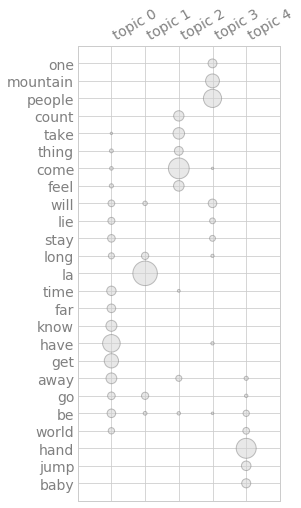

In [16]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,
                   topics=-1,  n_terms=25, sort_terms_by='seriation')